# Data Analysis and Processing Notebook

Project : Addressing Inequity in Medical Specialist Distribution in Thailand

Author : P. Sitthirat et al.

This notebook serves as a comprehensive guide for processing and analyzing health workforce data. It includes data scraping, cleaning, and analysis

**Objectives:**
- Scrape physicians data from MOPH database http://gishealth.moph.go.th.
- Apply data cleaning techniques.
- Analyse the ratio-to-population and inequity index.
- Visualize the changes along specific period.

**Requirements:**
Ensure the following libraries are installed before running the notebook:
`pip install -r scripts/requirements.txt`

## 1. Initial Setup and Library Imports

This cell initializes the notebook with necessary configurations and imports key libraries and custom modules for data processing, analysis, and specialty scraping.

### Features:
1. **IPython Extensions**:
   - `%load_ext autoreload`: Automatically reloads modules before executing cells, ensuring the latest code changes are applied.
   - `%autoreload 2`: Reloads all imported modules every time a cell is executed.

2. **Library Imports**:
   - `pandas`: For data manipulation and analysis.
   - `numpy`: For numerical operations.
   - `os`: For interacting with the operating system.
   - `itertools`: For creating efficient iterators.
   - `warnings`: To handle and suppress warnings.
   - `tqdm`: For progress bars in loops.
   - `matplotlib` and `plotly`: For building the graph

3. **Custom Modules** from `scripts` folder:
   - `scrp_spc`: For scraping workforce data from external sources.
   - `process`: For data cleaning and processing.
   - `analyse`: For data analysis.

4. **Notebook Settings**:
   - `pd.set_option('future.no_silent_downcasting', True)`: Ensures that pandas raises warnings for downcasting operations.
   - `warnings.simplefilter('ignore', DeprecationWarning)`: Suppresses deprecation warnings for a cleaner output.
   - `plt.rcParams.update`: Standardise the graph style

### Code:
This configuration ensures an efficient and clean working environment for data analysis and processing.

In [34]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import itertools
import warnings
from tqdm import tqdm
from scripts import scrp_spc
from scripts import process
from scripts import analyse
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import math
from IPython.display import clear_output

pd.set_option('display.max_rows', 300)
pd.set_option('future.no_silent_downcasting', True)
warnings.simplefilter('ignore', DeprecationWarning)

# Set a standardized style of graph
plt.rcParams.update({
    "font.size": 10,  # Standard font size for high-impact journals
    "font.family": "Arial",  # Standard font
    "axes.linewidth": 1,  # Line thickness
    "grid.alpha": 0.6,  # Grid transparency
    "grid.linestyle": "--",  # Grid style
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Import Datasets: Hospital, Population, and Workforce Data

This section imports and processes the following datasets:
1. **Healthcare Facility Registry Dataset**: Dataset for health facility registry from the Office of the Permanent Secretary (OPS), Ministry of Public Health, Thailand. This dataset includes comprehensive information on the location, type, and administrative hierarchy of healthcare facilities and health regions
2. **National Population Registry Database**: Dataset for population and household numbers in each administrative area, disaggregated from country to village levels. This dataset is annually publicized by the Bureau of Registration Administration, Ministry of Interior, Thailand.
3. **Physician and Specialist Dataset**: Dataset for physician and specialist numbers, self-reported from each hospital in both public and private sectors.

---

### 2.1 Healthcare Facility Registry Dataset

Source : [Healthcare Facility Registry Dataset](https://hcode.moph.go.th/code/)

**Key Steps**:
1. Load hospital data using the `DataCleaning.clean` method.
2. Filter out hospitals with a status of "ยกเลิก" (cancelled).
3. Standardize the hospital code format.
4. **Retain Only Hospitals**:
   - Exclude other facilities like provincial/district health offices, private clinics, or units without admissions.
   - Include only specified hospital types:
     - Private hospitals.
     - Hospitals under OPS: General, Regional, and Community hospitals.
     - Hospitals under other ministries such as the Ministry of Higher Education, Science, Research and Innovation (MHERI), Ministry of Defence, and local government.
5. Save the cleaned dataset to `output/clean/hosp_cleaned.csv`.
6. Compute and display summary statistics for total, public, and private hospitals.

**Notes**:
- The cleaned dataset ensures a standardized and focused hospital registry for further analysis.
- The `DataCleaning.clean` method simplifies preprocessing by applying consistent cleaning rules.

In [2]:
# Import Thailand hospital data
hosp_file = 'hosp'
data_dir = 'data'
output_dir = 'output/clean'

hosp, hosp_raw, dict_path = process.DataCleaning.clean(hosp_file, data_dir, output_dir, clear=True)
hosp = hosp[(hosp['status'] != 'ยกเลิก')]
hosp['hcode'] = hosp['hcode'].apply(lambda x: x[2:-1]) #convert hcode from ="xxxxx" to xxxxx
hosp = hosp[hosp['htype'].isin(['โรงพยาบาลเอกชน', 'โรงพยาบาล นอก สธ.', 'โรงพยาบาล นอก สป.สธ.', 'โรงพยาบาลชุมชน', 'โรงพยาบาลทั่วไป', 'โรงพยาบาลศูนย์'])].copy()
hosp.to_csv('output/clean/hosp_cleaned.csv')

# Hospital descriptive
hosp_total = len(hosp)
hosp_public = len(hosp[hosp['hgroup']=='รัฐบาล'])
hosp_private = len(hosp[hosp['hgroup']=='เอกชน'])

print(
      "----------------------------------------------------",
      "\nTotal hospital:" , hosp_total,
      "\nTotal public hospital:", hosp_public,
      "\nTotal private hospital:", hosp_private,
      "\n----------------------------------------------------")

File name                : hosp
Path to data dictionary  : data/data_dict-hosp.xlsx
Path to cleaned dataset  : output/clean/hosp_cleaned.csv
---------------------------------------------------- 
Total hospital: 1570 
Total public hospital: 1103 
Total private hospital: 467 
----------------------------------------------------


### 2.2 National Population Registry Database

Source : [National Population Registry Database](https://stat.bora.dopa.go.th/new_stat/webPage/statByYear.php)

**Key Steps**:
1. Iterate over population files for the years 2014–2023.
2. Load each file and standardize column names using a data dictionary.
3. Process population data for the following levels:
   - **Country**: Extract national population data and save it to `output/clean/pop_country.csv`.
   - **Province**: Extract population data by province and save it to `output/clean/pop_prov.csv`.
   - **District**: Aggregate and clean data by district and save it to `output/clean/pop_dist.csv`.
   - **Health Region**: Map provinces to health regions [see details](https://en.wikipedia.org/wiki/Healthcare_in_Thailand), aggregate population data, and save it to `output/clean/pop_hregion.csv`. 

**Notes**:
- The dataset provides comprehensive population and household statistics, disaggregated from the country level to individual villages.
- The preprocessing ensures consistency across multiple years and enables multi-level analysis.
- The mapping of provinces to health regions enhances regional-level analysis for healthcare planning. This mapping is saved in `output/map/map_prov.csv` and can be reused for other analyses. It provides a standardized reference for associating provinces with their respective health regions, ensuring consistency in future opportunities or projects.

---

**Details of Mapping File (`map_prov.csv`)**:
- **Location**: `output/map/map_prov.csv`
- **Contents**:
  - `prov`: The official names of provinces in Thai.
  - `parameter_map`: Designations of the corresponding health regions.

**Utility**:
- This mapping file can be applied to other datasets requiring regional aggregation, such as healthcare facility datasets or disease surveillance data.
- It ensures a consistent framework for associating provinces with their health regions, saving time and reducing errors in future analyses.

In [3]:
# Import Thailand population data
hosp_file = 'pop'
data_dir = 'data/pop'
output_dir = 'output/clean'

years = range(2015,2025)

pop_country = pd.DataFrame()
pop_hregion = pd.DataFrame()
pop_prov = pd.DataFrame()
pop_dist = pd.DataFrame()

for year in years:
    
    hosp_file = f'data/pop/pop_{year}.xlsx'
    pop = pd.read_excel(hosp_file, sheet_name='pop')
    pop = process.DataCleaning.update_column_name(pop, 'data/pop/data_dict-pop.xlsx')

    pop['prov'] = pop['prov'].apply(lambda x: x if x in ['กรุงเทพมหานคร', 'ทั่วประเทศ'] else x[7:])
    pop['year'] = year
    
    # Create population dataset in country level
    country = pop[pop['prov_id'] == 0][['year', 'prov', 'pop']]
    pop_country = pd.concat([pop_country, country], ignore_index=True)
    pop_country.to_csv('output/clean/pop_country.csv')
    
    # Create population dataset in provincial level
    prov = pop[(pop['prov_id'] != 0) & (pop['dist_id'] == 0) & (pop['subdist_id'] == 0) & (pop['village_id'] == 0)][['year', 'prov', 'prov_id', 'pop']]
    pop_prov = pd.concat([pop_prov, prov], ignore_index=True)
    pop_prov.to_csv('output/clean/pop_prov.csv')

    # Create population dataset in district level
    dist = pop[pop['subdist_id'] != 0][['year', 'subdist_id', 'pop']]
    dist['subdist_id'] = dist['subdist_id'].astype(str)
    dist['subdist_id'] = dist['subdist_id'].apply(lambda x: x[:-4])
    dist.rename(columns=lambda x: x.replace('subdist_id', 'dist_id') if x.startswith('subdist_id') else x, inplace=True)
    dist = dist.groupby(['year', 'dist_id']).sum().reset_index()
    pop_dist = pd.concat([pop_dist, dist], ignore_index=True)
    pop_dist.to_csv('output/clean/pop_dist.csv')

    # Create population dataset in health regional level
    hregion = prov.copy()
    hregion = process.DataManipulation.mapping(hregion, 'prov')
    hregion.rename(columns=lambda x: x.replace('prov', 'hregion') if x.startswith('prov') else x, inplace=True)
    hregion = hregion.groupby(['year', 'hregion']).sum().reset_index()
    hregion['hregion_id'] = hregion['hregion'].apply(lambda x: x[-2:] if len(x) == 15 else x[-1:])
    pop_hregion = pd.concat([pop_hregion, hregion], ignore_index=True)

clear_output()

### 2.3 Physician and Specialist Dataset

Source: [Physician and Specialist Dataset](http://gishealth.moph.go.th)

**Key Steps**:
1. **Run or Load Data**:
   - The program prompts the user to decide whether to scrape the data or load previously saved data:
     - **Option Y**: Initiates the scraping process to gather updated information.
     - **Option N**: Loads the specialist dataset from the previously saved file at `output/scraped/spc.csv`.

2. **Scraping Process**:
   - **Input Data**:
     - `hosp_id`: List of hospital codes to scrape. This is derived from `hosp['hcode']`, which is processed from the healthcare facility dataset in [Section 2.1](#21-hospital-dataset).
     - `spc_link`: URLs used for retrieving personal and specialty information. The scraping process constructs URLs in the format:
       ```
       http://gishealth.moph.go.th/healthmap/<link>.php?maincode=<hosp_id>
       ```
       The `link` parameter specifies the type of data to retrieve:
       - `infopersonal`: Workforce dataset (including physicians, dentists, nurses, etc., though this function specifically scrapes physician data).
       - `infospecialty`, `infospecialty2`, `infospecialty3`, `infospecialty4`, `infospecialty5`: Medical specialist datasets for various specialty types.

   - **Output**:
     - Scraped data is saved in `output/scraped/spc.csv`.
     - A detailed log of the scraping process, including metadata and errors, is saved in `output/scraped/readme.txt`.
     - The resulting DataFrame is loaded into `spc_df` for further analysis or processing.

3. **Load Existing Data**:
   - If the scraping process is skipped, the program attempts to load the dataset from `output/scraped/spc.csv`.
   - If the file does not exist, an error message is displayed, prompting the user to run the scraping process to generate the necessary data.

**Notes**:
- **Data Sources**: The GIS Health Map provides updated and detailed workforce and specialist data.
- **Directory Structure**:
  - Scraped data is stored in `output/scraped/`.
  - Metadata and logs are saved in `output/scraped/readme.txt`.
- **Key Advantages**:
  - Ensures the latest data is always accessible through the scraping process.
  - Allows reusability of previously saved data, minimizing redundant scraping efforts.


In [4]:
scrp = input("Would you like to run the scraping process? (Y/N): ").strip().upper()
output_dir = 'output/scraped'

if scrp == 'Y':

    hosp_id = pd.DataFrame({
        'hosp_id': hosp['hcode']
    })

    spc_link = pd.DataFrame({
        'link': ['infopersonal', 'infospecialty', 'infospecialty2', 'infospecialty3', 'infospecialty4', 'infospecialty5']
    })

    spc_path = scrp_spc.scrap(hosp_id, spc_link, output_dir)
    spc_df = pd.read_csv(spc_path)
    
elif scrp == 'N':
    
    # Use previously saved data
    spc_path = os.path.join(output_dir, 'spc.csv')
    
    if os.path.exists(spc_path):
        spc_df = pd.read_csv(spc_path)
        print(f"Data from '{spc_path}' has been successfully loaded and processed.")
    else:
        print(f"Error: The file '{spc_path}' does not exist. Please run the scraping first.")

Data from 'output/scraped/spc.csv' has been successfully loaded and processed.


## 3. Manipulate and Impute the Data

This section processes and imputes the specialist dataset (`spc_df`) to ensure completeness, accuracy, and consistency. A copy of the original dataset is created to preserve the integrity of the source data.

---

### 3.1 Check the completeness of data
The completeness of the data was analyzed before further processing:
- The dataset was merged with hospital metadata to evaluate the number and percentage of hospitals reporting data annually, categorized by type (public or private).
- The average percentage of hospital participation was calculated for each type.
- A time-series line graph illustrates trends in hospital data submission percentages over the years.

In [5]:
# Check the completeness of data
df = spc_df.copy()

# Format hospital ID and clean time data
df['hosp_id'] = df['hosp_id'].apply(lambda x: f'{x:05}') # Format to 5 digits
df = df[df['time'] != 'ไม่มีการบันทึกข้อมูล']
df['time'] = df['time'].apply(lambda x: int(x[-4:]) - 543) # Convert BE to CE
df.rename(columns={'time': 'year'}, inplace=True)
df['spc'] = df['spc'].apply(lambda x: 'แพทย์' if x == 'นายแพทย์' else x)
df = pd.merge(df, hosp[['hcode', 'htype']], how='left', left_on='hosp_id', right_on='hcode')
df['type_gr'] = df['htype'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

# Remove duplicate rows
df = df.drop_duplicates(keep='first')
df = df[df['year'] >= 2015]

complete = df.groupby(['year', 'type_gr'])['hosp_id'].nunique().reset_index(name='count')
# Add percent column with proper formatting
complete['percent'] = complete.apply(
    lambda row: f"{(row['count'] / 459) * 100:.2f}" if row['type_gr'] == 'private' 
                else f"{(row['count'] / 1101) * 100:.2f}", axis=1
)

# Convert the 'percent' column to numeric for calculations (removing string formatting)
complete['percent'] = complete['percent'].astype(float)

# Calculate the average percentage for each type group
average_percent = complete.groupby('type_gr')[['count', 'percent']].mean()

# Assuming `complete` is a DataFrame with columns 'year', 'percent', and 'type_gr'
fig = go.Figure()

# Grouping data by 'type_gr' and adding a trace for each group
for group in complete['type_gr'].unique():
    group_data = complete[complete['type_gr'] == group]
    fig.add_trace(go.Scatter(
        x=group_data['year'],
        y=group_data['percent'],
        mode='lines+markers',
        name=group  # Use the group name as the legend entry
    ))

# Updating layout and axis titles
fig.update_layout(
    title="Completeness by Year and Type Group",
    xaxis_title="Year",
    yaxis_title="Percent Completeness (%)",
    title_font_size=16,
    legend_title="Hospital Type",
    legend_title_font_size=12,
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    template="plotly_white"
)

# Displaying the results
print("Average percentage completeness:")
print(average_percent)
fig.show()


Average percentage completeness:
         count  percent
type_gr                
private  199.0   43.354
public   946.8   85.995


### 3.2 Outlier detection and impute the missing data
To ensure the dataset is complete, reliable, and ready for analysis, this step focuses on detecting outliers and imputing missing data. A comprehensive approach is applied to clean and organize the data while maintaining the integrity of the original dataset. This includes handling invalid or missing values, standardizing formats, and correcting anomalies. Below are the key steps involved:

**Key Steps**:

1. **Create a Copy of the Dataset**:
   - A copy of the original `spc_df` is created (`df = spc_df.copy()`) to preserve the raw data and perform all manipulations on the copy.

2. **Format and Clean Data**:
   - **Standardize Hospital IDs**: Convert `hosp_id` values to 5-digit strings for uniformity.
   - **Filter Invalid Records**: Exclude records with missing or invalid time data (`time != 'ไม่มีการบันทึกข้อมูล'`).
   - **Convert Buddhist Era (BE) Years to Common Era (CE)**: Adjust `time` values by subtracting 543.
   - **Standardize Specialty Names**: Replace `นายแพทย์` with `แพทย์` for consistency.
   - **Remove Duplicates**: Drop duplicate records based on `hosp_id`, `spc`, `time`, and `total`.

3. **Identify Data Completeness**:
   - **Required Years**: Define the range of years from 2014 to 2023.
   - **Group Analysis**:
     - **Physicians**: Identify hospitals with complete data for physicians across all required years.
     - **Specialists**: Identify hospitals with complete data for specialists across all required years.
   - **Output**: Display the counts of hospitals with complete data for both physicians and specialists.

4. **Handle Missing Values and Outliers**:
   - Replace `NaN` values in the `total` column with `0`.
   - Detect and correct outliers in the `total` column using the `outlier_loo` method:
     - Employ backward imputation for missing or anomalous values.

5. **Generate Complete Combinations of Data**:
   - Create all possible combinations of `hosp_id`, `spc`, and `time` for the range 2014–2024.
   - Merge the full combination set with the existing dataset to fill gaps in the data.

6. **Impute Missing Data**:
   - Apply forward-filling (`ffill`) to impute missing values for each combination of `hosp_id` and `spc`.

7. **Aggregate and Save**:
   - **Map and Standardize Specialty Names**: Use the `DataManipulation.mapping` function to ensure consistency in specialty names.
   - **Group and Aggregate Data**: Sum values grouped by `hosp_id`, `spc`, and `time`.
   - **Rename Columns**: Rename the `time` column to `year` for clarity.
   - **Export Cleaned Data**: Save the final cleaned dataset to `data/spc_aggregated.csv`.

---

**Output**:
- **Cleaned Data**: Saved as `data/spc_aggregated.csv`.
- **Mapped Data**: Specialty mapping details saved in `output/map/map_spc.csv`.
- **Summary Statistics**:
  - Number of hospitals with complete physician data over 10 years.
  - Number of hospitals with complete specialist data over 10 years.

**Notes**:
- Creating a copy of the dataset (`df = spc_df.copy()`) ensures the original data remains unaltered for future reference.
- Mapping detailed specialties into broader groups reduces complexity and enables focused analysis.
- The forward-fill imputation method ensures data continuity while filling in historical gaps.
- Outlier detection and correction enhance the reliability and validity of the dataset.
- The final processed dataset is ready for downstream analysis, providing consistent, complete, and clean information across all years and hospitals.
- Creating a copy of cleaned dataset (`df_original = df.copy()`) for sensitivity analysis


In [ ]:
df = spc_df.copy()

# Format hospital ID and clean time data
df['hosp_id'] = df['hosp_id'].apply(lambda x: f'{x:05}') # Format to 5 digits
df = df[df['time'] != 'ไม่มีการบันทึกข้อมูล']
df['time'] = df['time'].apply(lambda x: int(x[-4:]) - 543) # Convert BE to CE
df['spc'] = df['spc'].apply(lambda x: 'แพทย์' if x == 'นายแพทย์' else x)

# Remove duplicate rows
df = df.drop_duplicates(keep='first')

# Identify hospitals with complete data for the required years (2014–2023)
required_years = set(range(2015, 2025))
physicians = df[df['spc'] == 'แพทย์']
specialists = df[df['spc'] != 'แพทย์']

complete_physician = physicians.groupby('hosp_id')['time'].apply(lambda x: set(x) >= required_years)
complete_specialist = specialists.groupby('hosp_id')['time'].apply(lambda x: set(x) >= required_years)

# Display counts of hospitals with complete data
print(f"Number of hospitals with complete physician data: {complete_physician.sum()}")
print(f"Number of hospitals with complete specialist data: {complete_specialist.sum()}")

df_original = df.copy() #--> for sensitivity analysis
process.DataManipulation.mapping(df_original, 'spc')
df_original = df_original.groupby(['hosp_id', 'spc', 'time']).sum().reset_index()
df_original.rename(columns={'time': 'year'}, inplace=True)

# Handle missing values and outliers
df['total'] = df['total'].fillna(0) #From self-reported, we considered the NaN values as 'zero' 
groups = df.groupby(['hosp_id', 'spc'], as_index=False)
for name, group in tqdm(groups, desc="Processing Groups"):
    modified_group, modified = process.DataManipulation.outlier_loo(group, 'total', 'time', include_columns=['hosp_id', 'spc'], mse_threshold_ratio=0.01, impute='backward', print_outliers=False)
    if modified:
        df.loc[modified_group.index, :] = modified_group

# Fill missing years and forward-fill missing data
hosp_ids, spcs, years = df['hosp_id'].unique(), df['spc'].unique(), range(2015, 2025)
full_years = pd.DataFrame(itertools.product(hosp_ids, spcs, years), columns=['hosp_id', 'spc', 'time'])
df = pd.merge(full_years, df, how='left', on=['hosp_id', 'spc', 'time'])
df = df.groupby(['hosp_id', 'spc']).apply(lambda group: group.ffill()).reset_index(drop=True)

# Remove duplicate rows
df = df.drop_duplicates(keep='last')

# Map the specialist group and aggreagate the data
process.DataManipulation.mapping(df, 'spc')
df = df.groupby(['hosp_id', 'spc', 'time']).sum().reset_index()

# Export the processed data
processed_path = 'data/spc_aggregated.csv'
df.rename(columns={'time': 'year'}, inplace=True)
df.to_csv(processed_path)
print(f"Processed dataset was saved in {processed_path}. Please use this dataset for further analysis.")

Number of hospitals with complete physician data: 24
Number of hospitals with complete specialist data: 31


## 4. Analysis

In this section, we perform a comprehensive analysis of the cleaned dataset to understand the distribution of medical specialists across various regions and time periods. The analysis includes:

- **Descriptive Statistics**: Summarizing the data to provide insights into the central tendency, dispersion, and shape of the distribution of specialist counts.
- **Trend Analysis**: Observing how the number of specialists has evolved over the specified time frame.
- **Geographical Distribution**: Examining the allocation of specialists across different provinces and health regions.
- **Equity Assessment**: Evaluating the fairness in the distribution of specialists using statistical measures such as the Gini coefficient.

The results from this analysis will inform policy recommendations aimed at achieving a more equitable distribution of medical specialists nationwide.

In [9]:
# Import the cleaned data for analysis
df, df_raw, dict_path = process.DataCleaning.clean('spc_aggregated', 'data', 'output/clean')
clear_output()
df = df[(df['year'] >= 2015) & (df['year'] <= 2024)]
df['hosp_id'] = df['hosp_id'].apply(lambda x: f'{x:05}') # Format to 5 digits
df = pd.merge(df, hosp[['hcode', 'prov', 'dist_id', 'hregion', 'htype']], how='left', left_on='hosp_id', right_on='hcode')
df['dist_id'] = df['dist_id'].astype(int).astype(str)
df['type_gr'] = df['htype'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

df_foranalyse = df.copy()

In [10]:
# Analyse the total number of hospitals
df = df_foranalyse.copy()
n_hosp = len(df['hosp_id'].unique())
n_hosp_public = len(df[df['type_gr'] == 'public']['hosp_id'].unique())
n_hosp_private = len(df[df['type_gr'] == 'private']['hosp_id'].unique())

print(
      "----------------------------------------------------",
      "\nIncluded hospital in this analysis"
      "\nTotal hospital:" , n_hosp,
      "\nTotal public hospital:", n_hosp_public,
      "\nTotal private hospital:", n_hosp_private,
      "\n----------------------------------------------------")

---------------------------------------------------- 
Included hospital in this analysis
Total hospital: 1478 
Total public hospital: 1088 
Total private hospital: 390 
----------------------------------------------------


Descriptive Table for Physician


,1,28
spc,Physician,Physician
total_grand,22868.0,46854.0
total_public,17978.0,35896.0
percentage_public,78.62%,76.61%
total_private,4890.0,10958.0
percentage_private,21.38%,23.39%


,13
spc,Physician
crude_increase_per_year,2665.111111


,13
spc,Physician
pct_total,10.87765
pct_public,11.800669
pct_private,9.600508


Descriptive Table for Generalist


,0,27
spc,Generalist,Generalist
total_grand,2011.0,5945.0
total_public,1673.0,5058.0
percentage_public,83.19%,85.08%
total_private,338.0,887.0
percentage_private,16.81%,14.92%


,4
spc,Generalist
crude_increase_per_year,437.111111


,4
spc,Generalist
pct_total,18.512223
pct_public,20.476595
pct_private,12.528119


Descriptive Table for Specialist


,2,29
spc,Specialist,Specialist
total_grand,14058.0,35980.0
total_public,10392.0,26821.0
percentage_public,73.92%,74.54%
total_private,3666.0,9159.0
percentage_private,26.08%,25.46%


,18
spc,Specialist
crude_increase_per_year,2435.777778


,18
spc,Specialist
pct_total,11.976884
pct_public,12.356819
pct_private,11.177244


Ratio of medical doctors to 100,000 population in public hospitals for generalist and specialist


,1,28
spc,Physician,Physician
ratio,27.351661,54.428114


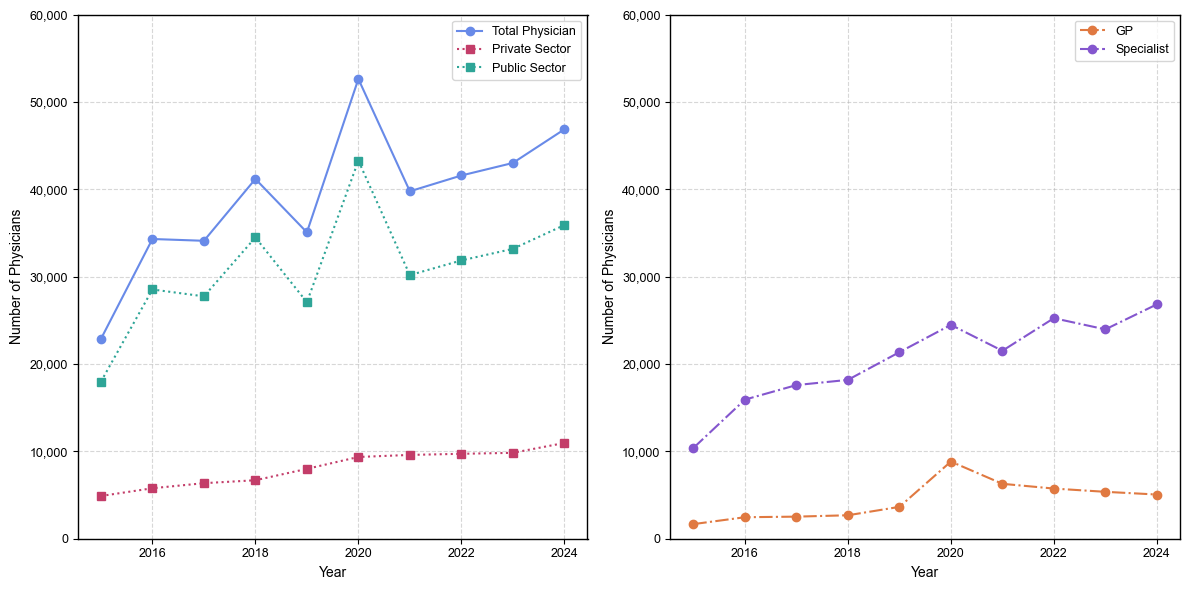

In [15]:
# Analyse the desciptive of total doctors 
df = df_foranalyse.copy()
mapping = {'General Practitioner': 'Generalist', 'Physician': 'Physician'}
df['spc_type'] = df['spc'].map(mapping).fillna('Specialist')

# Create pivot data for total physician and specialist number
total_gr = df.pivot_table(index=['year', 'spc_type'], values='total', aggfunc='sum', fill_value=0).reset_index()
total_gr.rename(columns={'spc_type': 'spc'}, inplace=True) 
total_spc = df[df['spc'] != 'Physician'].pivot_table(index=['year', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
total = pd.concat([total_gr, total_spc], ignore_index=True)

# Create pivot data for total physician and specialist number in public sector
public_gr = df[df['type_gr'] == 'public'].pivot_table(index=['year', 'spc_type'], values='total', aggfunc='sum', fill_value=0).reset_index()
public_gr.rename(columns={'spc_type': 'spc'}, inplace=True) 
public_spc = df[(df['spc'] != 'Physician') & (df['type_gr'] == 'public')].pivot_table(index=['year', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
public = pd.concat([public_gr, public_spc], ignore_index=True)

# Merge the pivot data and calculate the ratio-to-population
total = pd.merge(total, public, how='left', on=['year', 'spc'], suffixes=('_grand', '_public'))
total['total_private'] = total['total_grand'] - total['total_public']
total['percentage_public'] = total.apply(lambda row: f'{((row['total_public']/row['total_grand'])*100):.2f}%', axis=1)
total['percentage_private'] = total.apply(lambda row: f'{((row['total_private']/row['total_grand'])*100):.2f}%', axis=1)
total = pd.merge(total, pop_country[['year', 'pop']], how='left', on='year')
total['ratio'] = total['total_public']/(total['pop']/100000)

total.sort_values(by=['spc', 'year'], inplace=True)
total['crude_increase_per_year'] = total.groupby('spc')['total_grand'].diff()
total[['pct_total', 'pct_public', 'pct_private']] = total.groupby('spc')[['total_grand', 'total_public', 'total_private']].pct_change() * 100

average_crude_increase = total.groupby('spc')['crude_increase_per_year'].mean().reset_index()
average_changes = total.groupby('spc')[['pct_total', 'pct_public', 'pct_private']].mean().reset_index()
average_combined = pd.merge(average_crude_increase, average_changes, how='inner', on='spc')

total.to_csv('output/analyse/Table 1A Total Numbers of Physician and Specilist.csv')
average_changes.to_csv('output/analyse/Table 1B Changes Physician and Specilist.csv')

for gr in ['Physician', 'Generalist', 'Specialist']:
    print(f'Descriptive Table for {gr}')
    display(total[(total['spc'] == gr) & (total['year'].isin([2015, 2024]))][['spc', 'total_grand', 'total_public', 'percentage_public', 'total_private', 'percentage_private']].T)
    display(average_crude_increase[average_crude_increase['spc'] == gr].T)
    display(average_changes[average_changes['spc'] == gr].T)

print('Ratio of medical doctors to 100,000 population in public hospitals for generalist and specialist')
display(total[(total['spc'] == 'Physician') & (total['year'].isin([2015, 2024]))][['spc', 'ratio']].T)

#------------------------------------------

# Build the graph

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1. Line graph for 'Physician' with columns: total_grand, total_private, total_public
physician_data = total[total['spc'] == 'Physician']
axes[0].plot(physician_data['year'], physician_data['total_grand'], label='Total Physician', marker='o', linestyle='-', color='#688ae8')
axes[0].plot(physician_data['year'], physician_data['total_private'], label='Private Sector', marker='s', linestyle=':', color='#c33d69')
axes[0].plot(physician_data['year'], physician_data['total_public'], label='Public Sector', marker='s', linestyle=':', color='#2ea597')

# Add details to the first subplot
axes[0].set_title('', fontsize=12, weight='bold')
axes[0].set_xlabel('Year', fontsize=10)
axes[0].set_ylim(0,60000)
axes[0].set_ylabel('Number of Physicians', fontsize=10)
axes[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.5)
axes[0].tick_params(axis='both', which='major', labelsize=9)

# 2. Line graph for 'Generalist' and 'Specialist' for total_public
generalist_data = total[total['spc'] == 'Generalist']
specialist_data = total[total['spc'] == 'Specialist']

axes[1].plot(generalist_data['year'], generalist_data['total_public'], label='GP', marker='o', linestyle='-.', color='#e07941')
axes[1].plot(specialist_data['year'], specialist_data['total_public'], label='Specialist', marker='o', linestyle='-.', color='#8456ce')

# Add details to the second subplot
axes[1].set_title('', fontsize=12, weight='bold')
axes[1].set_xlabel('Year', fontsize=10)
axes[1].set_ylim(0,60000)
axes[1].set_ylabel('Number of Physicians', fontsize=10)
axes[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.5)
axes[1].tick_params(axis='both', which='major', labelsize=9)

# Adjust layout for better readability
plt.tight_layout()

# Save as a high-resolution figure for publication
# plt.savefig("standardized_line_chart.png", dpi=300)
plt.show()

In [16]:
# Analyse the health regions, provincial, and district levels

df = df_foranalyse.copy()
df['dist_id'] = df['dist_id'].astype(int).astype(str)
df['type_gr'] = df['htype'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

df_public = df[df['type_gr'] == 'public']

# Region level
df_hregion = df_public.pivot_table(index=['year', 'hregion', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_hregion = pd.merge(df_hregion, pop_hregion[['year', 'hregion', 'pop']], how='left', on=['year', 'hregion'])
df_hregion['den'] = df_hregion['total']/(df_hregion['pop']/100000)
df_hregion.to_csv('output/analyse/Table 2 Density in health region level.csv')

# Province level
df_prov = df_public.pivot_table(index=['year', 'prov', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_prov = pd.merge(df_prov, pop_prov[['year', 'prov', 'pop']], how='left', on=['year', 'prov'])
df_prov['den'] = df_prov['total']/(df_prov['pop']/100000)
df_prov.to_csv('output/analyse/Table 3 Density in provincial level.csv')

# District level
df_dist = df_public.pivot_table(index=['year', 'dist_id', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_dist = pd.merge(df_dist, pop_dist[['year', 'dist_id', 'pop']], how='left', on=['year', 'dist_id'])
df_dist['den'] = df_dist['total']/(df_dist['pop']/100000)
df_dist.to_csv('output/analyse/Table 4 Density in district level.csv')

In [19]:
def run_coverage_inequity(df_public, df_hregion, df_prov, df_dist, years):
    result_cov = []
    result_ineq = []

    for year in years:
        df_y = df_public[df_public['year'] == year]

        for spc in sorted(df_public['spc'].unique()):
            df_spc = df_y[df_y['spc'] == spc]

            # --- Coverage ---
            result_cov.append({
                'year': year,
                'spc': spc,
                'n_spc': df_spc['total'].sum(),
                'cov_hregion': analyse.coverage(df_hregion.query("year==@year & spc==@spc"), 'total', 'hregion'),
                'cov_prov': analyse.coverage(df_prov.query("year==@year & spc==@spc"), 'total', 'prov'),
                'cov_dist': analyse.coverage(df_dist.query("year==@year & spc==@spc"), 'total', 'dist')
            })

            # --- Inequity ---
            result_ineq.append({
                'year': year,
                'spc': spc,
                'G_hregion': analyse.gini(df_hregion.query("year==@year & spc==@spc"), 'total', 'pop'),
                'G_prov': analyse.gini(df_prov.query("year==@year & spc==@spc"), 'total', 'pop'),
                'G_dist': analyse.gini(df_dist.query("year==@year & spc==@spc"), 'total', 'pop'),
                'T_hregion': analyse.theil_T(df_hregion.query("year==@year & spc==@spc"), 'total', 'pop'),
                'T_prov': analyse.theil_T(df_prov.query("year==@year & spc==@spc"), 'total', 'pop'),
                'T_dist': analyse.theil_T(df_dist.query("year==@year & spc==@spc"), 'total', 'pop')
            })

    return pd.DataFrame(result_cov), pd.DataFrame(result_ineq)

In [ ]:
years = range(2015, 2025)
cov_imp, ineq_imp = run_coverage_inequity(
    df_public, df_hregion, df_prov, df_dist, years
)

display("Coverage analysis", cov_imp.head())
display("Inequity analysis", ineq_imp.head())

cov_imp.to_csv('output/analyse/Table 5 Coverage of Specialists.csv')
ineq_imp.to_csv('output/analyse/Table 6 Inequity distribution of Specialist.csv')

# pre-imputed dataset



'Coverage analysis'

,year,spc,n_spc,cov_hregion,cov_prov,cov_dist
0,2015,Anesthesiology,544.0,13 (100.00%),62 (80.52%),115 (12.39%)
1,2015,Emergency Medicine,183.0,13 (100.00%),42 (54.55%),53 (5.71%)
2,2015,Family Medicine,543.0,13 (100.00%),66 (85.71%),194 (20.91%)
3,2015,General Practitioner,1673.0,13 (100.00%),70 (90.91%),257 (27.69%)
4,2015,Gynecology,924.0,13 (100.00%),69 (89.61%),186 (20.04%)


'Inequity analysis'

,year,spc,G_hregion,G_prov,G_dist,T_hregion,T_prov,T_dist
0,2015,Anesthesiology,0.348694,0.523640,0.873316,0.216905,0.480607,2.030962
1,2015,Emergency Medicine,0.349920,0.612135,0.926319,0.199882,0.746063,2.381451
2,2015,Family Medicine,0.219886,0.423027,0.829324,0.075504,0.302342,1.622577
3,2015,General Practitioner,0.168089,0.417190,0.808044,0.044522,0.300943,1.394404
4,2015,Gynecology,0.238997,0.414342,0.811418,0.093928,0.311311,1.485319


In [46]:
# Analyse the health regions, provincial, and district levels

df_sens = df_original.copy()
df_sens = df_sens[(df_sens['year'] >= 2015) & (df_sens['year'] <= 2024)]
df_sens['hosp_id'] = df_sens['hosp_id'].apply(lambda x: f'{x:05}') # Format to 5 digits
df_sens = pd.merge(df_sens, hosp[['hcode', 'prov', 'dist_id', 'hregion', 'htype']], how='left', left_on='hosp_id', right_on='hcode')
df_sens['dist_id'] = df_sens['dist_id'].astype(int).astype(str)
df_sens['type_gr'] = df_sens['htype'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')
df_sens['dist_id'] = df_sens['dist_id'].astype(int).astype(str)
df_sens['type_gr'] = df_sens['htype'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

In [65]:
key_cols = ['hosp_id', 'spc', 'year']

# Mark original observations
df_sens['is_original'] = True

# Merge original into imputed dataset
df_compare = df_foranalyse.merge(
    df_sens[key_cols + ['is_original']],
    on=key_cols,
    how='left'
)

# Observation affected by imputation
df_compare['is_imputed'] = df_compare['is_original'].isna()

prop_obs_imputed = df_compare['is_imputed'].mean()
print(f'Proportion of observations affected by imputation: {prop_obs_imputed}')

# define full study years
FULL_YEARS = set(range(2015, 2025))
N_YEARS = len(FULL_YEARS)

# count reported years per hospital-specialty
year_count = (
    df_sens
    .groupby(['hosp_id'])['year']
    .nunique()
    .reset_index(name='n_reported_years')
)

# calculate missing years
year_count['n_missing_years'] = N_YEARS - year_count['n_reported_years']

# flags
year_count['impute_any'] = year_count['n_missing_years'] > 0
year_count['impute_gt1'] = year_count['n_missing_years'] > 1
year_count['impute_gt5'] = year_count['n_missing_years'] > 5

display(year_count.head())
prop_obs_imputed_any = year_count['impute_any'].mean()
prop_obs_imputed_gt1 = year_count['impute_gt1'].mean()
prop_obs_imputed_gt5 = year_count['impute_gt5'].mean()
print(prop_obs_imputed_any, prop_obs_imputed_gt1, prop_obs_imputed_gt5)

year_count = year_count.merge(hosp[['hcode', 'hgroup', 'hregion']], left_on='hosp_id', right_on='hcode', how='left')

ratio_by_hgroup = (
    year_count
    .groupby('hgroup')
    .agg(
        n_units=('hosp_id', 'count'),
        prop_impute_any=('impute_any', 'mean'),
        prop_impute_gt1=('impute_gt1', 'mean'),
        prop_impute_gt5=('impute_gt5', 'mean')
    )
    .reset_index()
)

display(ratio_by_hgroup)

ratio_by_hregion = (
    year_count
    .groupby('hregion')
    .agg(
        n_units=('hosp_id', 'count'),
        prop_impute_any=('impute_any', 'mean'),
        prop_impute_gt1=('impute_gt1', 'mean'),
        prop_impute_gt5=('impute_gt5', 'mean')
    )
    .reset_index()
)

display(ratio_by_hregion)

Proportion of observations affected by imputation: 0.534261765148098


,hosp_id,n_reported_years,n_missing_years,impute_any,impute_gt1,impute_gt5
0,04007,8,2,True,True,False
1,06009,9,1,True,False,False
2,09192,7,3,True,True,False
3,10660,7,3,True,True,False
4,10661,10,0,False,False,False


0.778382053025153 0.4479945615227736 0.1257647858599592


,hgroup,n_units,prop_impute_any,prop_impute_gt1,prop_impute_gt5
0,รัฐบาล,1088,0.708640,0.286765,0.031250
1,เอกชน,383,0.976501,0.906005,0.394256


,hregion,n_units,prop_impute_any,prop_impute_gt1,prop_impute_gt5
0,เขตสุขภาพที่ 1,155,0.716129,0.354839,0.090323
1,เขตสุขภาพที่ 10,85,0.670588,0.270588,0.023529
2,เขตสุขภาพที่ 11,124,0.758065,0.419355,0.064516
3,เขตสุขภาพที่ 12,102,0.882353,0.343137,0.098039
4,เขตสุขภาพที่ 13,162,0.981481,0.876543,0.203704
5,เขตสุขภาพที่ 2,68,0.676471,0.397059,0.117647
6,เขตสุขภาพที่ 3,73,0.767123,0.315068,0.082192
7,เขตสุขภาพที่ 4,126,0.753968,0.468254,0.206349
8,เขตสุขภาพที่ 5,114,0.701754,0.464912,0.210526
9,เขตสุขภาพที่ 6,148,0.790541,0.506757,0.229730


In [45]:
df_public_sens = df_sens[df_sens['type_gr'] == 'public']

# Region level
df_hregion_sens = df_public_sens.pivot_table(index=['year', 'hregion', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_hregion_sens = pd.merge(df_hregion_sens, pop_hregion[['year', 'hregion', 'pop']], how='left', on=['year', 'hregion'])
df_hregion_sens['den'] = df_hregion_sens['total']/(df_hregion_sens['pop']/100000)

# Province level
df_prov_sens = df_public_sens.pivot_table(index=['year', 'prov', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_prov_sens = pd.merge(df_prov_sens, pop_prov[['year', 'prov', 'pop']], how='left', on=['year', 'prov'])
df_prov_sens['den'] = df_prov_sens['total']/(df_prov_sens['pop']/100000)

# District level
df_dist_sens = df_public_sens.pivot_table(index=['year', 'dist_id', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_dist_sens = pd.merge(df_dist_sens, pop_dist[['year', 'dist_id', 'pop']], how='left', on=['year', 'dist_id'])
df_dist_sens['den'] = df_dist_sens['total']/(df_dist_sens['pop']/100000)

years = range(2015, 2025)
cov_sens, ineq_sens = run_coverage_inequity(
    df_public_sens, df_hregion_sens, df_prov_sens, df_dist_sens, years
)

display("Coverage analysis", cov_sens.head())
display("Inequity analysis", ineq_sens.head())

'Coverage analysis'

,year,spc,n_spc,cov_hregion,cov_prov,cov_dist
0,2015,Anesthesiology,544.0,13 (100.00%),62 (80.52%),115 (12.39%)
1,2015,Emergency Medicine,183.0,13 (100.00%),42 (54.55%),53 (5.71%)
2,2015,Family Medicine,543.0,13 (100.00%),66 (85.71%),194 (20.91%)
3,2015,General Practitioner,1673.0,13 (100.00%),70 (90.91%),257 (27.69%)
4,2015,Gynecology,924.0,13 (100.00%),69 (89.61%),186 (20.04%)


'Inequity analysis'

,year,spc,G_hregion,G_prov,G_dist,T_hregion,T_prov,T_dist
0,2015,Anesthesiology,0.348694,0.507982,0.783419,0.216905,0.448266,1.494696
1,2015,Emergency Medicine,0.349920,0.604680,0.865835,0.199882,0.727026,1.782130
2,2015,Family Medicine,0.219886,0.404063,0.708211,0.075504,0.270001,1.086311
3,2015,General Practitioner,0.168089,0.398034,0.671830,0.044522,0.268602,0.858138
4,2015,Gynecology,0.238997,0.395092,0.630607,0.093928,0.278971,0.812993


In [39]:
# Sensitivity analysis

# Provincial level
ineq_compare_prov = (
    ineq_imp[['year','spc','G_prov']]
    .merge(
        ineq_sens[['year','spc','G_prov']],
        on=['year','spc'],
        suffixes=('_imputed', '_raw')
    )
)

ineq_compare_prov['abs_diff'] = (
    ineq_compare_prov['G_prov_imputed'] - ineq_compare_prov['G_prov_raw']
).abs()

# Health region level
ineq_compare_hregion = (
    ineq_imp[['year','spc','G_hregion']]
    .merge(
        ineq_sens[['year','spc','G_hregion']],
        on=['year','spc'],
        suffixes=('_imputed', '_raw')
    )
)

ineq_compare_hregion['abs_diff'] = (
    ineq_compare_hregion['G_hregion_imputed'] - ineq_compare_hregion['G_hregion_raw']
).abs()

display(ineq_compare_prov.head())
display(ineq_compare_hregion.head())
display(ineq_compare_prov['abs_diff'].describe())
display(ineq_compare_hregion['abs_diff'].describe())
ineq_compare_prov.to_csv('output/analyse/Table 7A Sensitivity analyses compare Gini in speciality and years in provincial level.csv')
ineq_compare_hregion.to_csv('output/analyse/Table 7B Sensitivity analyses compare Gini in speciality and years in health region level.csv')


,year,spc,G_prov_imputed,G_prov_raw,abs_diff
0,2015,Anesthesiology,0.523640,0.507982,0.015657
1,2015,Emergency Medicine,0.612135,0.604680,0.007455
2,2015,Family Medicine,0.423027,0.404063,0.018964
3,2015,General Practitioner,0.417190,0.398034,0.019156
4,2015,Gynecology,0.414342,0.395092,0.019250


,year,spc,G_hregion_imputed,G_hregion_raw,abs_diff
0,2015,Anesthesiology,0.348694,0.348694,0.0
1,2015,Emergency Medicine,0.349920,0.349920,0.0
2,2015,Family Medicine,0.219886,0.219886,0.0
3,2015,General Practitioner,0.168089,0.168089,0.0
4,2015,Gynecology,0.238997,0.238997,0.0


count    180.000000
mean       0.069456
std        0.057129
min        0.000543
25%        0.016666
50%        0.064037
75%        0.105780
max        0.370159
Name: abs_diff, dtype: float64

count    180.000000
mean       0.057119
std        0.054274
min        0.000000
25%        0.015349
50%        0.048487
75%        0.084960
max        0.477219
Name: abs_diff, dtype: float64

In [43]:
df = ineq_compare_prov.sort_values(['spc','year']).copy()

def smooth_metrics(g):
    d = g.diff()
    return pd.Series({
        "sd": g.std(ddof=1),
        "mad_delta": d.abs().mean(),
        "roughness": (d**2).sum()
    })

prov_metrics = (
    df.groupby('spc')
      .apply(lambda x: pd.concat([
          smooth_metrics(x['G_prov_imputed']).add_prefix('imp_'),
          smooth_metrics(x['G_prov_raw']).add_prefix('raw_')
      ]))
      .reset_index()
)

prov_metrics['mad_delta_ratio'] = prov_metrics['imp_mad_delta'] / prov_metrics['raw_mad_delta']
prov_metrics['sd_ratio'] = prov_metrics['imp_sd'] / prov_metrics['raw_sd']
prov_metrics['roughness_ratio'] = prov_metrics['imp_roughness'] / prov_metrics['raw_roughness']

prov_metrics.describe()

/var/folders/bf/rp_bmxh57x748ppg9b4stxy80000gn/T/ipykernel_45771/2750331967.py:13: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,imp_sd,imp_mad_delta,imp_roughness,raw_sd,raw_mad_delta,raw_roughness,mad_delta_ratio,sd_ratio,roughness_ratio
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.049686,0.037046,0.021582,0.061254,0.080877,0.095364,0.489807,0.890761,0.317981
std,0.018840,0.007233,0.007582,0.023070,0.027597,0.100617,0.130487,0.391180,0.157810
min,0.030562,0.025054,0.008908,0.039541,0.044357,0.033365,0.230116,0.210592,0.043087
25%,0.035378,0.032897,0.015795,0.051435,0.061963,0.044165,0.416618,0.625645,0.221552
50%,0.043950,0.035988,0.021749,0.057795,0.079996,0.076855,0.468383,0.723920,0.273725
75%,0.053791,0.042909,0.026669,0.065035,0.091001,0.092802,0.563226,1.326891,0.432002
max,0.093652,0.052997,0.039784,0.145124,0.163513,0.479523,0.743041,1.478354,0.627356


In [44]:
df = ineq_compare_hregion.sort_values(['spc','year']).copy()

hregion_metrics = (
    df.groupby('spc')
      .apply(lambda x: pd.concat([
          smooth_metrics(x['G_hregion_imputed']).add_prefix('imp_'),
          smooth_metrics(x['G_hregion_raw']).add_prefix('raw_')
      ]))
      .reset_index()
)

hregion_metrics['mad_delta_ratio'] = hregion_metrics['imp_mad_delta'] / hregion_metrics['raw_mad_delta']
hregion_metrics['sd_ratio'] = hregion_metrics['imp_sd'] / hregion_metrics['raw_sd']
hregion_metrics['roughness_ratio'] = hregion_metrics['imp_roughness'] / hregion_metrics['raw_roughness']

hregion_metrics.describe()

/var/folders/bf/rp_bmxh57x748ppg9b4stxy80000gn/T/ipykernel_45771/339069453.py:5: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,imp_sd,imp_mad_delta,imp_roughness,raw_sd,raw_mad_delta,raw_roughness,mad_delta_ratio,sd_ratio,roughness_ratio
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.037966,0.041581,0.025139,0.077592,0.105692,0.159231,0.401782,0.536020,0.195610
std,0.009177,0.013126,0.013270,0.031567,0.035424,0.164605,0.091575,0.176422,0.103391
min,0.023796,0.015237,0.004097,0.038850,0.044374,0.027100,0.271187,0.267351,0.057943
25%,0.030256,0.034060,0.014955,0.057318,0.087056,0.087082,0.346689,0.412816,0.133109
50%,0.040123,0.043029,0.024946,0.070558,0.099563,0.108676,0.393011,0.489439,0.184858
75%,0.045302,0.049817,0.033178,0.088799,0.122657,0.164048,0.449822,0.699981,0.228777
max,0.054518,0.062077,0.047894,0.175663,0.185657,0.771085,0.680262,0.856391,0.529031


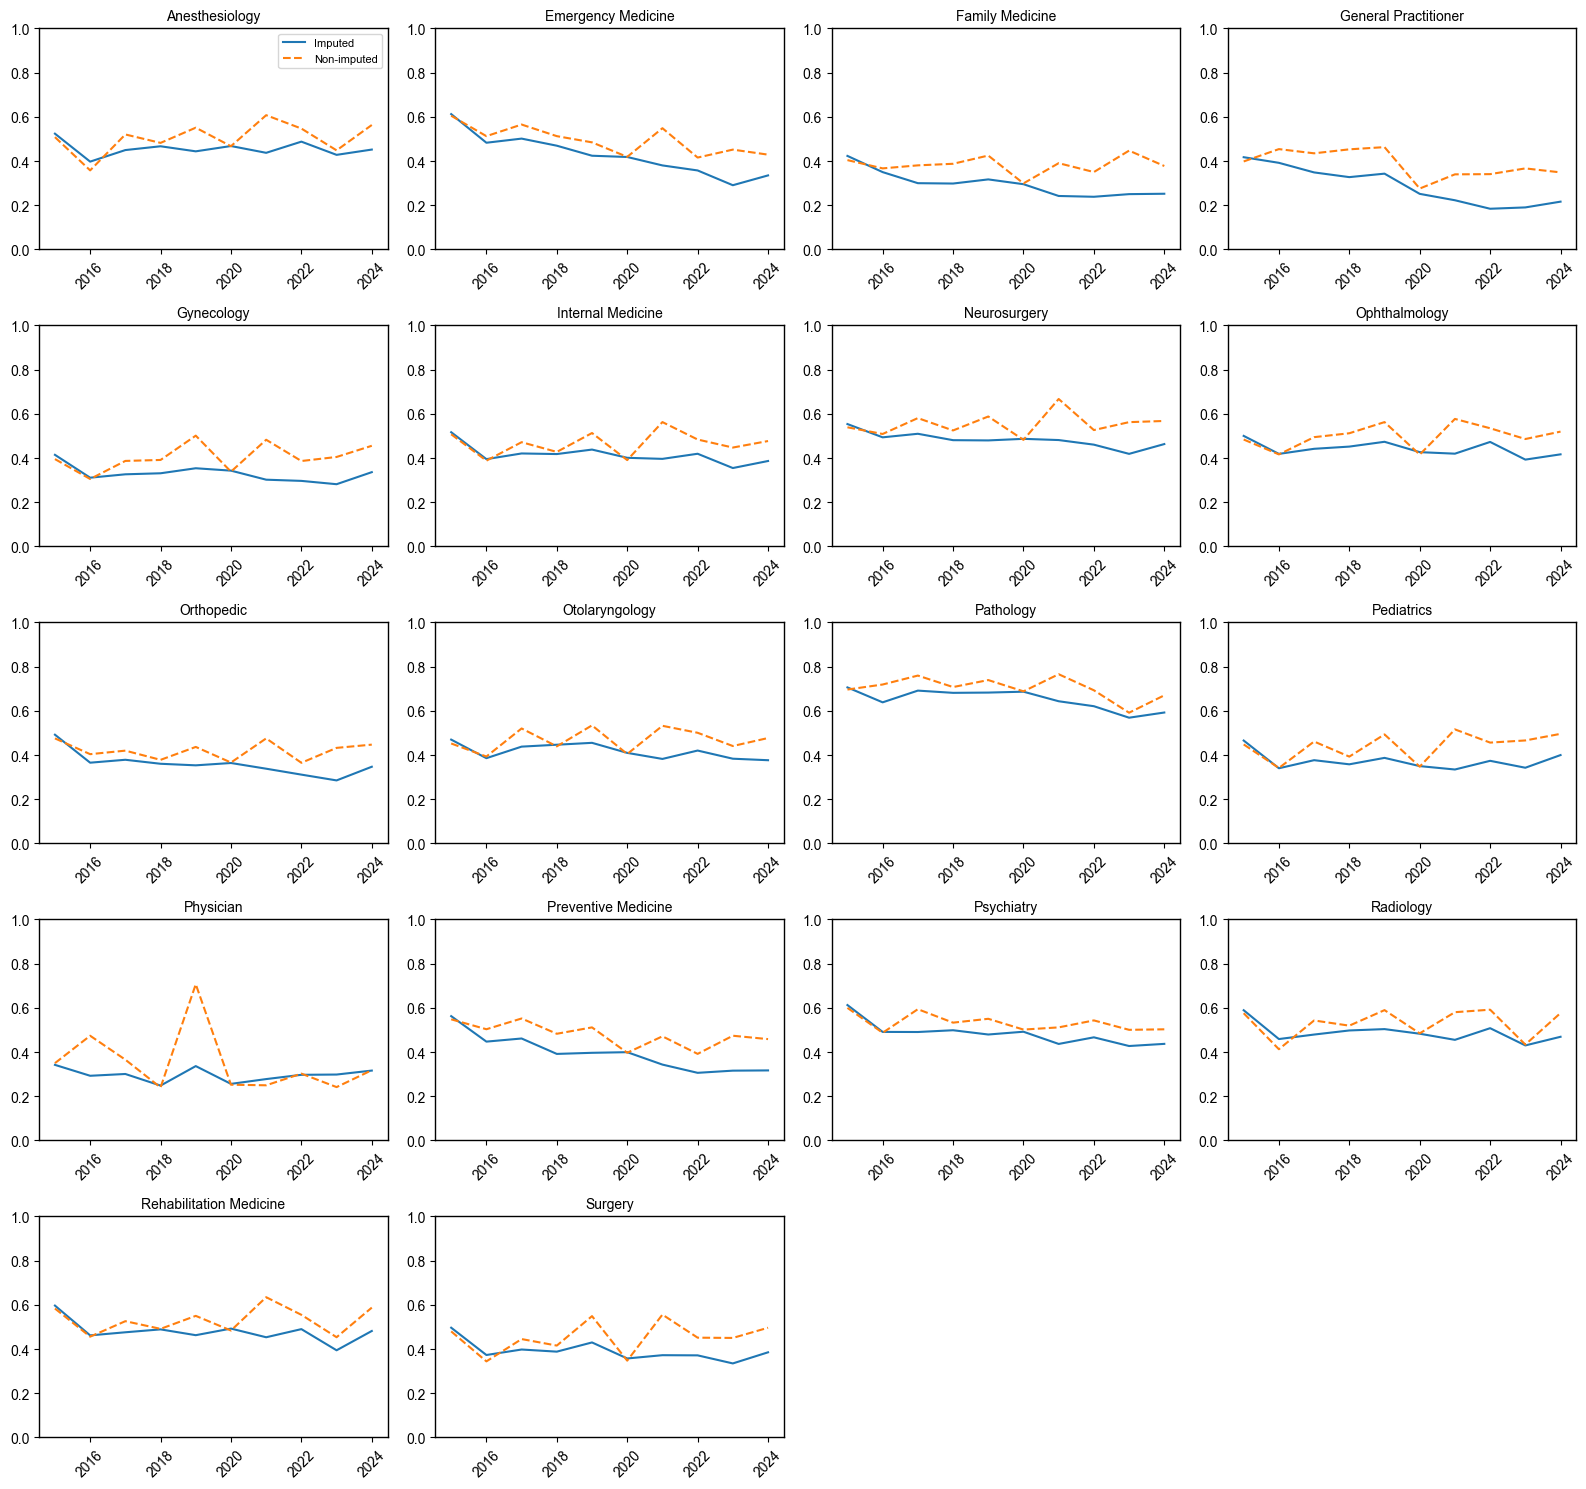

In [41]:
plot_sens = ineq_compare_prov.copy()

specialties = sorted(plot_sens['spc'].unique())
n_spc = len(specialties)

# layout
n_cols = 4
n_rows = math.ceil(n_spc / n_cols)

plt.figure(figsize=(4*n_cols, 3*n_rows))

for i, spc in enumerate(specialties, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    
    df_spc = plot_sens[plot_sens['spc'] == spc]
    
    ax.plot(df_spc['year'], df_spc['G_prov_imputed'], label='Imputed')
    ax.plot(df_spc['year'], df_spc['G_prov_raw'], linestyle='--', label='Non-imputed')
    
    ax.set_title(spc, fontsize=10)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    if i == 1:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

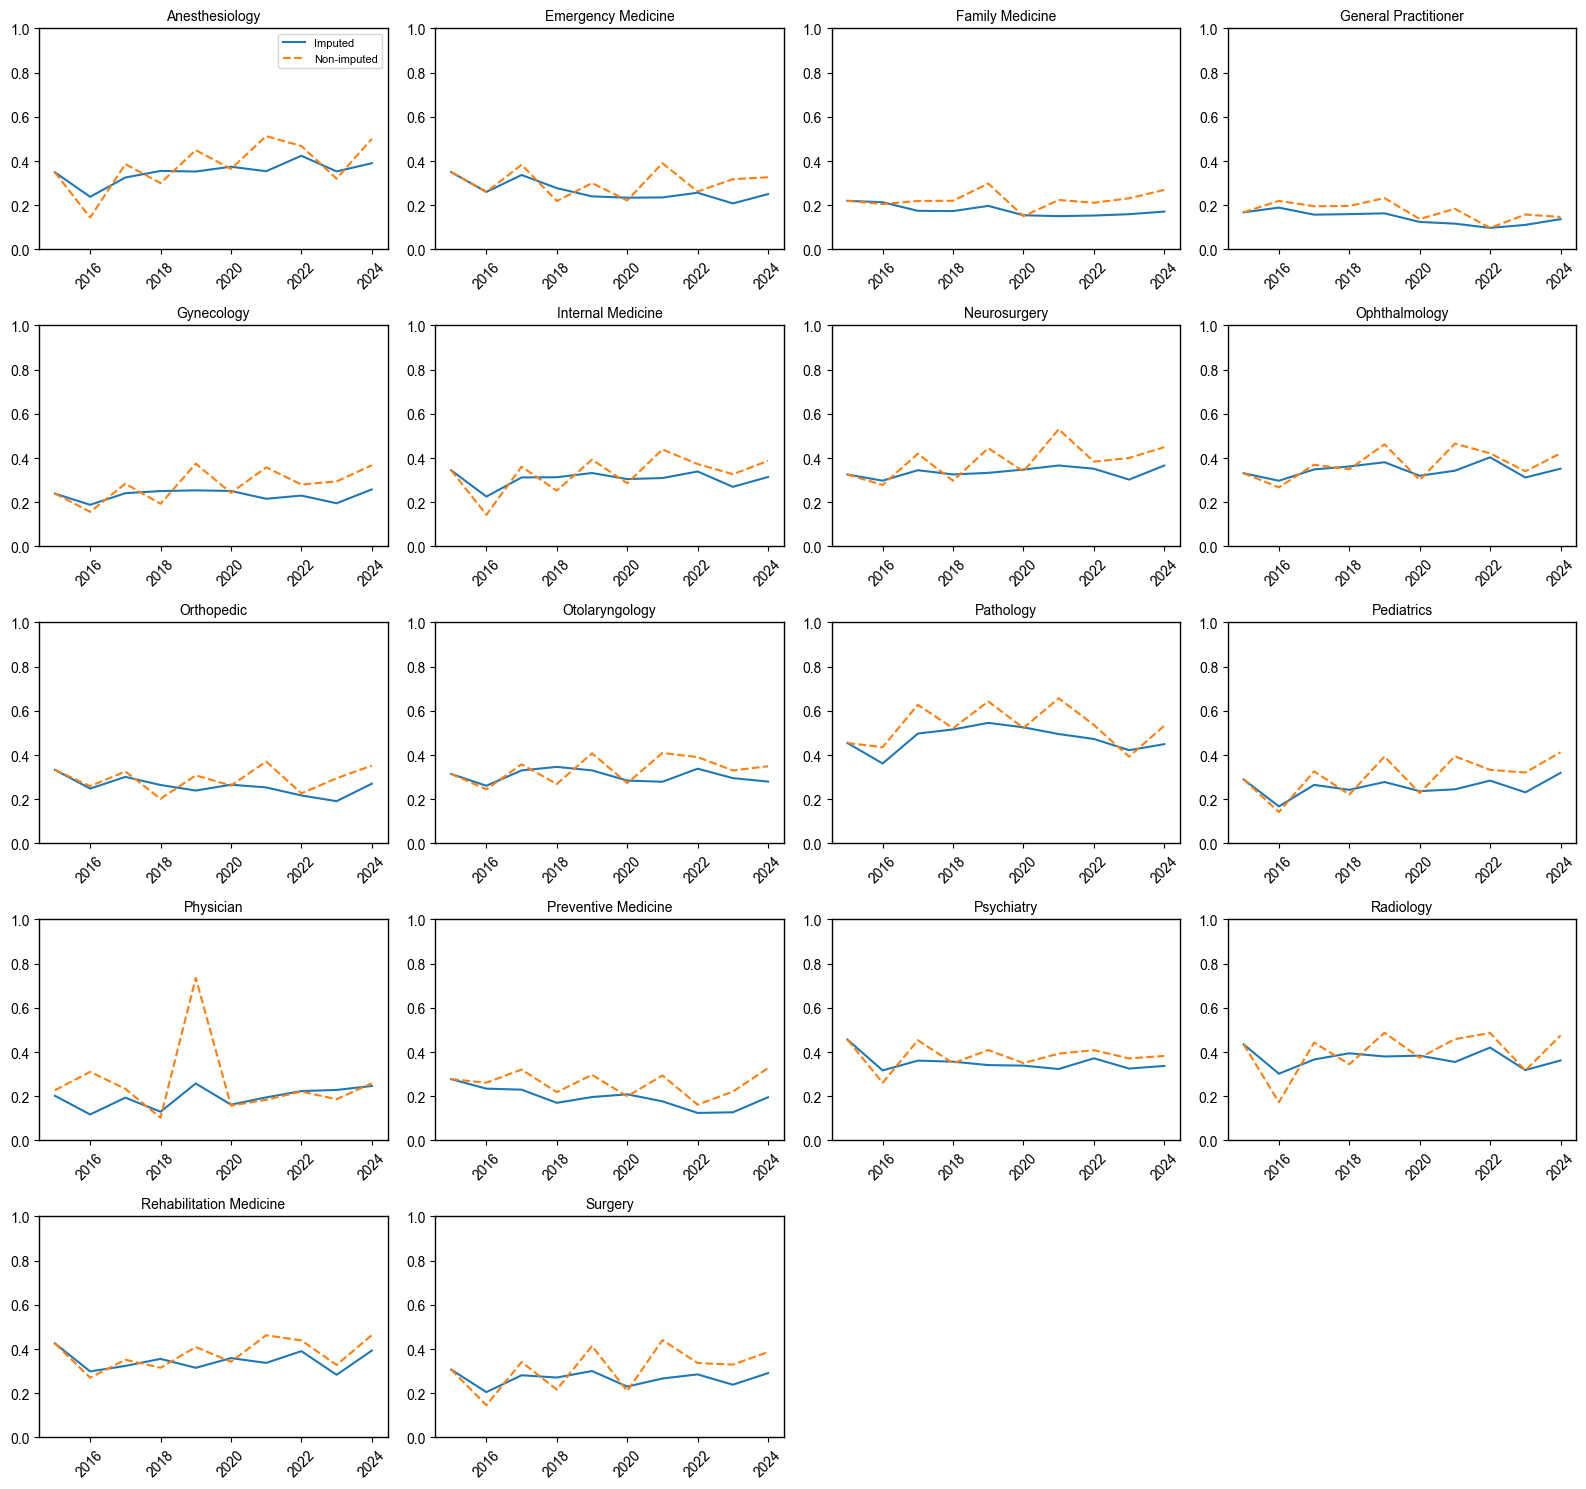

In [42]:
plot_sens = ineq_compare_hregion.copy()

specialties = sorted(plot_sens['spc'].unique())
n_spc = len(specialties)

# layout
n_cols = 4
n_rows = math.ceil(n_spc / n_cols)

plt.figure(figsize=(4*n_cols, 3*n_rows))

for i, spc in enumerate(specialties, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    
    df_spc = plot_sens[plot_sens['spc'] == spc]
    
    ax.plot(df_spc['year'], df_spc['G_hregion_imputed'], label='Imputed')
    ax.plot(df_spc['year'], df_spc['G_hregion_raw'], linestyle='--', label='Non-imputed')
    
    ax.set_title(spc, fontsize=10)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    if i == 1:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()